# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Как всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [1]:
!pip install sympy

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
     |████████████████████████████████| 5.6 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 508 kB 3.1 MB/s eta 0:00:01
Using legacy 'setup.py install' for mpmath, since package 'wheel' is not installed.
    Running setup.py install for mpmath ... done


In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
import sympy as sp

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or '≈'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []  # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        n_samples, n_features = X.shape

        # преобразование датасета в numpy массив, если передан Pandas датасет
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        # инициализация весов
        if self.w0 is None:
            self.w = np.zeros(n_features)
        else:
            self.w = self.w0.copy()

        for i in range(self.max_iter):
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n_samples)
                grad = self.calc_gradient(X[idx].reshape(1, -1), y[idx].reshape(1, -1))
            else:
                raise ValueError("Invalid gd_type. Use 'full' or 'stochastic'.")

            # обновляем веса
            prev_w = self.w.copy()
            # print('===>>>> self.w:', type(self.w), self.w.shape, self.w)
            # print('===>>>> grad:', type(grad), grad.shape, grad)
            self.w -= self.eta * grad

            # считаем loss и добавляем в лог
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                break

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        # сигмоида
        z = np.dot(X, self.w)
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        n_samples = X.shape[0]
        z = np.dot(X, self.w)
        predictions = 1 / (1 + np.exp(-z))
        errors = predictions - y
        gradient = np.dot(X.T, errors) / n_samples

        # преобразуем gradient в одномерный массив
        if gradient.ndim == 2 and gradient.shape[1] == 1:
            gradient = gradient.flatten()

        return gradient

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        n_samples = X.shape[0]
        z = np.dot(X, self.w)
        predictions = 1 / (1 + np.exp(-z))
        log_likelihood = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return log_likelihood

Теперь проверим работу вашего класса на синтетических данных.

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [5]:
model = LogReg(gd_type='full', tolerance=1e-4, max_iter=1000, eta=1e-2)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)

In [6]:
y_pred_proba

array([0.54357069, 0.86049465, 0.97217429, ..., 0.52505808, 0.65646479,
       0.75483507], shape=(30000,))

ROC-AUC: 0.9257363589480103


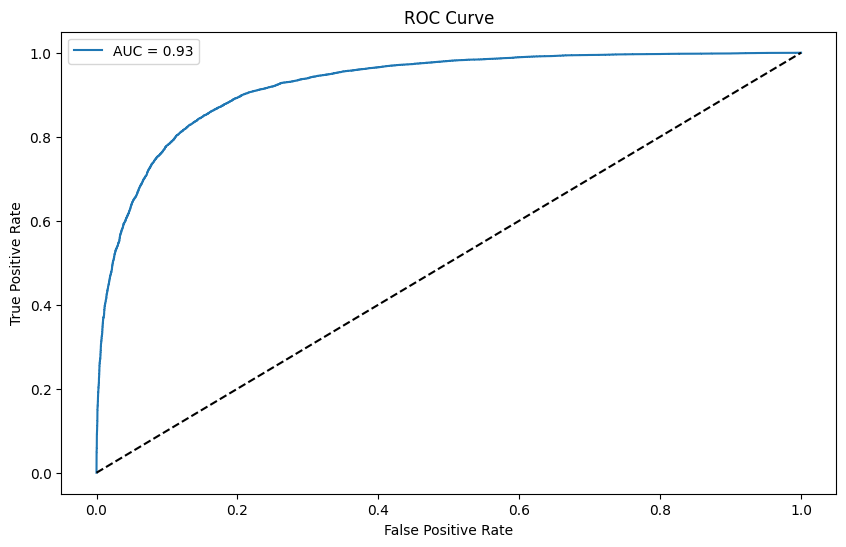

In [6]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

PR-AUC: 0.9241272253003949


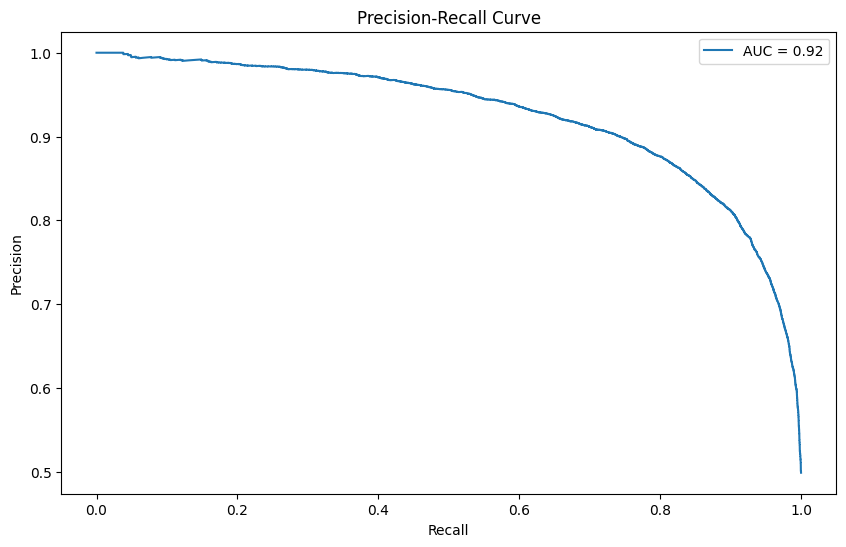

In [7]:
# PR-AUC
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"PR-AUC: {pr_auc}")

# PR кривая
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Интерпретация: На синтетических данных результаты хорошие, что видно по отображаемым ROC и PR кривым.

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные**

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [88]:
PATH_TO_DATASET = './train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [10]:
X_train.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,476169.000000,476169.000000,476169.000000,476169.000000,476169.00000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,...,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000
mean,1.900382,1.358923,4.424725,0.416715,0.40507,0.393581,0.256858,0.164083,0.185478,0.000361,...,5.442540,1.441774,2.873642,7.538842,0.122841,0.627744,0.554501,0.287364,0.348586,0.153662
std,1.983697,0.664595,2.701460,0.493296,1.35082,0.488544,0.436901,0.370351,0.388685,0.019002,...,2.334245,1.203968,1.693720,2.746594,0.328255,0.483407,0.497021,0.452533,0.476523,0.360625
min,0.000000,-1.000000,0.000000,-1.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,6.000000,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,7.000000,4.000000,11.000000,1.000000,6.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
381341,1,1,8,0,0,0,0,1,0,0,...,2,1,5,8,0,1,1,0,0,0
1327969,2,2,2,1,0,0,0,0,1,0,...,6,0,2,5,0,1,1,0,1,0
601794,0,1,2,0,0,1,0,0,0,0,...,9,1,5,3,0,0,0,0,1,1
632925,6,1,11,1,0,0,1,0,0,0,...,8,1,2,4,0,1,0,0,1,1
74864,3,1,5,1,0,0,0,1,0,0,...,9,2,3,8,0,1,1,1,0,0


In [9]:
# сколько признаков было до преобразований
X_train.shape

(476169, 57)

In [12]:
X_train.filter(like='_cat').shape

(476169, 14)

In [ ]:
# DELETE
X_train_cat = X_train.filter(like='_cat')
cat_columns = [col for col in X_train.columns if '_cat' in col]

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_cat_encoded = one_hot_encoder.fit_transform(X_train_cat)

encoded_feature_names = one_hot_encoder.get_feature_names_out(cat_columns)
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_feature_names)

X_train_cat_encoded_df.index = X_train.index

X_train = pd.concat([X_train.drop(cat_columns, axis=1), X_train_cat_encoded_df], axis=1)

In [6]:
def preprocessor(X):
  X_cat = X.filter(like='_cat')
  cat_columns = [col for col in X.columns if '_cat' in col]

  one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

  X_cat_encoded = one_hot_encoder.fit_transform(X_cat)

  encoded_feature_names = one_hot_encoder.get_feature_names_out(cat_columns)
  X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoded_feature_names)

  X_cat_encoded_df.index = X.index

  return pd.concat([X.drop(cat_columns, axis=1), X_cat_encoded_df], axis=1)

X_train = preprocessor(X_train)

In [34]:
# сколько признаков стало
X_train.shape # 213

(476169, 57)

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [49]:
X_train = X_train.iloc[:20000]
y_train = y_train[:20000]

In [50]:
y_train

array([0, 0, 0, ..., 0, 0, 0], shape=(20000,))

In [46]:
# логистическая регрессия
start_time = time.time()
log_reg_custom = LogReg(gd_type='stochastic', tolerance=1e-4, max_iter=1000, eta=1e-2)
log_reg_custom.fit(X_train, y_train)
end_time = time.time()
log_reg_custom_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_log_reg_custom = log_reg_custom.predict_proba(preprocessor(X_test))

# ROC-AUC для логистической регрессии
roc_auc_log_reg_custom = roc_auc_score(y_test, y_pred_proba_log_reg_custom)
print(f"Custom Logistic Regression ROC-AUC: {roc_auc_log_reg_custom}")
print(f"Custom Logistic Regression Training Time: {log_reg_custom_time:.2f} seconds")

Custom Logistic Regression ROC-AUC: 0.5169279161549685
Custom Logistic Regression Training Time: 0.79 seconds


In [49]:
# метод опорных векторов (SVM)
start_time = time.time()
svm = SVC(probability=True, random_state=42, cache_size=1000)
svm.fit(X_train, y_train)
end_time = time.time()
svm_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_svm = svm.predict_proba(preprocessor(X_test))[:, 1]

# ROC-AUC для SVM
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"SVM Training Time: {svm_time:.2f} seconds")

SVM ROC-AUC: 0.5281187129922772
SVM Training Time: 90.25 seconds


In [48]:
# Метод k ближайших соседей (k-NN)
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
end_time = time.time()
knn_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_knn = knn.predict_proba(preprocessor(X_test))[:, 1]

# ROC-AUC для k-NN
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print(f"k-NN ROC-AUC: {roc_auc_knn}")
print(f"k-NN Training Time: {knn_time:.2f} seconds")

k-NN ROC-AUC: 0.5110529662882347
k-NN Training Time: 0.01 seconds


In [50]:
# вывод
results = {
    'Model': ['My Logistic Regression', 'SVM', 'k-NN'],
    'ROC-AUC': [roc_auc_log_reg_custom, roc_auc_svm, roc_auc_knn],
    'Training Time (seconds)': [log_reg_custom_time, svm_time, knn_time]
}

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


Summary of Results:
                    Model   ROC-AUC  Training Time (seconds)
0  My Logistic Regression  0.516928                 0.791141
1                     SVM  0.528119                90.247171
2                    k-NN  0.511053                 0.012405


4.2

In [67]:
# DELETE
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        self.cat_columns = None
        self.encoded_feature_names = None

    def fit(self, X, y=None):
        self.cat_columns = [col for col in X.columns if '_cat' in col]
        if self.cat_columns:
            self.one_hot_encoder.fit(X[self.cat_columns])
            self.encoded_feature_names = self.one_hot_encoder.get_feature_names_out(self.cat_columns)
        return self

    def transform(self, X):
        if self.cat_columns is None:
            raise ValueError("Сначала нужно вызвать метод fit.")

        X_cat = X[self.cat_columns]
        if not X_cat.empty:
            X_cat_encoded = self.one_hot_encoder.transform(X_cat)
            X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=self.encoded_feature_names, index=X.index)
            X_transformed = pd.concat([X.drop(self.cat_columns, axis=1), X_cat_encoded_df], axis=1)
        else:
            X_transformed = X.copy()

        return X_transformed

In [9]:
X_train.describe()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
count,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.862400,4.44300,0.390100,0.260900,0.164200,0.184800,0.00025,0.002000,0.010000,0.001250,...,0.006650,0.003950,0.002500,0.004800,0.020900,0.007400,0.012650,0.003700,0.038650,0.140500
std,1.960755,2.70265,0.487785,0.439136,0.370466,0.388145,0.01581,0.044678,0.099501,0.035334,...,0.081278,0.062726,0.049939,0.069117,0.143053,0.085707,0.111761,0.060717,0.192764,0.347514
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,6.00000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,11.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# пайплайн для логистической регрессии
log_reg_pipeline = Pipeline([
    ('log_reg', LogisticRegression(max_iter=2000, tol=1e-4, random_state=42, solver='lbfgs'))
])

log_reg_param_grid = {
    'log_reg__C': [0.1, 1, 10],
    'log_reg__class_weight': [None, 'balanced']
}

start_time = time.time()
log_reg_grid_search = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=3, scoring='roc_auc')
log_reg_grid_search.fit(X_train, y_train)
end_time = time.time()
log_reg_training_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_log_reg = log_reg_grid_search.predict_proba(preprocessor(X_test))[:, 1]

# ROC-AUC для логистической регрессии
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f"Logistic Regression ROC-AUC: {roc_auc_log_reg}")
print(f"Logistic Regression Training Time: {log_reg_training_time:.2f} seconds")
print(f"Best parameters: {log_reg_grid_search.best_params_}")

Logistic Regression ROC-AUC: 0.608189663292019
Logistic Regression Training Time: 27.51 seconds
Best parameters: {'log_reg__C': 0.1, 'log_reg__class_weight': None}


In [14]:
# пайплайн для SVM
svm_pipeline = Pipeline([
    ('svm', SVC(probability=True))
])

svm_param_grid = {
    'svm__C': [0.1], #, 1, 10],
    'svm__kernel': ['linear'], #, 'rbf'],
    'svm__class_weight': [None]#, 'balanced']
}

start_time = time.time()
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=2, scoring='roc_auc', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
end_time = time.time()
svm_training_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_svm = svm_grid_search.predict_proba(preprocessor(X_test))[:, 1]

# ROC-AUC для SVM
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"SVM Training Time: {svm_training_time:.2f} seconds")
print(f"Best parameters: {svm_grid_search.best_params_}")

SVM ROC-AUC: 0.5154357869128515
SVM Training Time: 102.23 seconds
Best parameters: {'svm__C': 0.1, 'svm__class_weight': None, 'svm__kernel': 'linear'}


In [15]:
# пайплайн для KNN
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

start_time = time.time()
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring='roc_auc')
knn_grid_search.fit(X_train, y_train)
end_time = time.time()
knn_training_time = end_time - start_time

# предсказания вероятностей на тестовой выборке
y_pred_proba_knn = knn_grid_search.predict_proba(preprocessor(X_test))[:, 1]

# ROC-AUC для KNN
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print(f"KNN ROC-AUC: {roc_auc_knn}")
print(f"KNN Training Time: {knn_training_time:.2f} seconds")
print(f"Best parameters: {knn_grid_search.best_params_}")

KNN ROC-AUC: 0.5118074571429793
KNN Training Time: 4.49 seconds
Best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


In [16]:
results = {
    'Model': ['Logistic Regression', 'SVM', 'KNN'],
    'ROC-AUC': [roc_auc_log_reg, roc_auc_svm, roc_auc_knn],
    'Training Time (seconds)': [log_reg_training_time, svm_training_time, knn_training_time]
}

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


Summary of Results:
                 Model   ROC-AUC  Training Time (seconds)
0  Logistic Regression  0.608190                27.505141
1                  SVM  0.515436               102.232919
2                  KNN  0.511807                 4.493505


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)
- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [27]:
X_train.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
id,,,,,,,,,,,,,,,,,,,,,
381341,1,8,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1327969,2,2,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601794,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632925,6,11,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74864,3,5,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
y_train

array([0, 0, 0, ..., 0, 0, 0], shape=(16000,))

In [38]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

start_time = time.time()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_scaled, y_train)

# отбираем 150 признаков
weights = np.abs(lr.coef_[0])
top_features = np.argsort(weights)[-150:]  # индексы 150 лучших признаков
X_reduced = X_scaled[:, top_features]  # отбираем признаки

# оцениваем качество на 150 признаках
X_train_1, X_test, y_train, y_test = train_test_split(X_reduced, y_train, test_size=0.2, random_state=42)
lr_reduced = LogisticRegression(max_iter=1000, random_state=42)
lr_reduced.fit(X_train_1, y_train)
y_pred = lr_reduced.predict(X_test)

print("Accuracy после отбора признаков:", accuracy_score(y_test, y_pred))

Accuracy после отбора признаков: 0.96225


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [46]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# отбираем 200 признаков
top_200_features = np.argsort(weights)[-200:]
X_reduced_200 = X_scaled[:, top_200_features]

# отбираем 150 из 200
lr_200 = LogisticRegression(max_iter=1000, random_state=42)
lr_200.fit(X_reduced_200, y_train)
weights_200 = np.abs(lr_200.coef_[0])
top_150_features_final = np.argsort(weights_200)[-150:]
X_reduced_150 = X_reduced_200[:, top_150_features_final]

# оцениваем на 150 признаках
X_train_2, X_test, y_train, y_test = train_test_split(X_reduced_150, y_train, test_size=0.2, random_state=42)
lr_final = LogisticRegression(max_iter=1000, random_state=42)
lr_final.fit(X_train_2, y_train)
y_pred = lr_final.predict(X_test)

print("Accuracy после итеративного отбора:", accuracy_score(y_test, y_pred))

Accuracy после итеративного отбора: 0.96225


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [89]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# логистическая регрессия с L1-регуляризацией
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(lr_l1, param_grid, cv=3, scoring='accuracy')
grid.fit(X_scaled, y_train)

best_model = grid.best_estimator_
print("Лучшее значение C:", grid.best_params_['C'])

# подсчитываем ненулевые веса
non_zero_weights = np.sum(best_model.coef_ != 0)
rounded_weights = np.sum(np.round(best_model.coef_, 2) != 0)
print("Число ненулевых весов:", non_zero_weights)
print("Число весов после округления:", rounded_weights)

Лучшее значение C: 0.01
Число ненулевых весов: 33
Число весов после округления: 25


### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [52]:
PATH_TO_DATASET = './train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [56]:
categorical_cols = [col for col in X_train.columns if '_cat' in col]
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2 and col not in categorical_cols]
continuous_cols = [col for col in X_train.columns if col not in categorical_cols + binary_cols]

# масштабирование непрерывных признаков
scaler = StandardScaler()
X_scaled = X_train.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])

# подсчет t-статистики
start_time = time.time()
t_stats = {}
for col in continuous_cols:
    group1 = X_scaled[y_train == 0][col]
    group2 = X_scaled[y_train == 1][col]
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.var(ddof=1), group2.var(ddof=1)
    mu1, mu2 = group1.mean(), group2.mean()
    t_stat = abs(mu1 - mu2) / np.sqrt((n1 * s1 + n2 * s2) / (n1 + n2))
    t_stats[col] = t_stat

# отбор половины признаков с наибольшими t-статистиками
selected_continuous_cols = sorted(t_stats, key=t_stats.get, reverse=True)[:len(t_stats) // 2]

# объединение с категориальными и бинарными
selected_features = selected_continuous_cols + categorical_cols + binary_cols

# обучение
X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y_train, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# оценка качества
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
execution_time = time.time() - start_time

print(f"Отобрано {len(selected_features)} признаков.")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Время выполнения отбора признаков: {execution_time:.2f} секунд")

Отобрано 44 признаков.
ROC-AUC: 0.6270
Время выполнения отбора признаков: 10.79 секунд


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# пример отбора по 5 признаков
import time

start_time = time.time()

X_sample = X_train[:10000]
y_sample = y_train[:10000]

# удаляем по 5 признаков
num_features = X_sample.shape[1]
step = 5
removed_features = []
for i in range(0, num_features, step):
    test_features = list(range(num_features))
    del test_features[i:i+step]
    X_subset = X_sample[:, test_features]

    X_train, X_valid, y_train, y_valid = train_test_split(X_subset, y_sample, test_size=0.2, random_state=42)

    lr_wrapper = LogisticRegression(max_iter=1000, random_state=42)
    lr_wrapper.fit(X_train, y_train)
    score = lr_wrapper.score(X_valid, y_valid)
    print(f"Score при удалении {i}-{i+step} признаков: {score}")

end_time = time.time()
print("Время выполнения итерации:", end_time - start_time)

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

При отборе мы использовали наиболее простой способ - интерпретацию весов обученной модели для определения важности признака, то есть встроенный метод. Также попробовали реализовать итеративный отбор признаков. Затем мы использовали логистическую регрессию с L1-регуляризацией, которую можно применить к любой модели и которая позволяет избавиться от некоторых неважных признаков за счёт зануления их весов. Далее мы использовали фильтрационный метод с использованием статистики для отбора признаков, такие методы обычно имеют высокую скорость. И, в завершение, мы попробовали использовать обёрточный метод - самый точный, но самый долгий, метод, в котором используется жадный отбор.

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [2]:
PATH = './train_2.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [3]:
data.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [4]:
data.fillna('')

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,,,Police investigating after an e-bike collided ...,1


- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [5]:
data.dtypes

,0
id,int64
keyword,object
location,object
text,object
target,int64


In [6]:
num_cols = data.select_dtypes(include=['number'])
num_cols.nunique()

,0
id,7613
target,2


In [7]:
data['target'].unique()

array([1, 0])

Столбцов с числовыми признаками всего 2, но id мы не учитываем, поэтому только traget является интересным для нас признаком. Уникальных значений всего 2 (признак бинарный).

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [8]:
data['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


Это важно учитывать, чтобы дисбаланс не повлиял на качество модели. При выполнении задачи классификации и смещении данных в датасете мы имеем большое множество объектов одного класса и маленькое множество объектов другого класса. Если мы будем обучаться на таких данных, скорее всего произойдёт переобучении модели. Чтобы избежать этого необходимо использовать различные методы, которые позволяют уйти от дисбаланса классов в данных, например, Random Oversampling, Random Undersampling, SMOTE, ADASYN, Tomek links, SMOTEK, либо изменить веса loss-функции, пропорционально добавив значимости объектам из маленького множества, чтобы уравнять два класса.

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [9]:
data[['keyword', 'location', 'text']] = data[['keyword', 'location', 'text']].fillna('').astype(str)
data['text'] = data[['keyword', 'location', 'text']].agg(' '.join, axis=1)
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' ar...,1
3,6,,,"13,000 people receive #wildfires evacuation ...",1
4,7,,,Just got sent this photo from Ruby #Alaska a...,1


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [10]:
X = data['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
X_train.head()

,text
5151,"obliterate Dover, DE @dicehateme @PuppyShogun ..."
6351,"structural%20failure ÌÏT: 27.9136024,-81.60785..."
3443,"exploded Elmwood Park, NJ Well as I was chanin..."
7164,war%20zone Host of #MindMoversPodcast the war ...
7037,typhoon Obama Declares Disaster for Typhoon-D...


In [12]:
X_train.shape

(5709,)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [13]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print(f"Shape of the vectorized training data: {X_train_vectorized.shape}")
print(f"Shape of the vectorized test data: {X_test_vectorized.shape}")
print(vectorizer.get_feature_names_out()[:10])

Shape of the vectorized training data: (5709, 19370)
Shape of the vectorized test data: (1904, 19370)
['00' '000' '0000' '00cy9vxeff' '00end' '00pm' '01' '011072' '014213' '02']


- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [14]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_vectorized, y_train)

y_pred_log_reg = log_reg.predict(X_test_vectorized)

# оценка качества модели (F1-score)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted') # используем weighted для учета дисбаланса классов
print(f"F1-score for Logistic Regression: {f1_log_reg:.4f}")

F1-score for Logistic Regression: 0.7976


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [15]:
svm = SVC(probability=True)
start_time = time.time()
svm.fit(X_train_vectorized, y_train)
end_time = time.time()
training_time_svm = end_time - start_time

y_pred_svm = svm.predict(X_test_vectorized)

# оценка качества модели (F1-score)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1-score for SVM: {f1_svm:.4f}")
print(f"SVM Training Time: {training_time_svm:.2f} seconds")

F1-score for SVM: 0.8026
SVM Training Time: 34.72 seconds


Метод опорных векторов показывает хороший f1, однако обучается заметно дольше логистической регрессии, поэтому этот метод не следует использовать, когда есть требования быстроты.

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [19]:
param_grid = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'vectorizer__min_df': [1, 2, 5],
    'vectorizer__max_df': [0.95, 0.9, 0.8]
}

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# лучшие параметры
best_params_log_reg = grid_search.best_params_
best_f1_log_reg = grid_search.best_score_
print(f"Best parameters for Logistic Regression: {best_params_log_reg}")
print(f"Best F1-score for Logistic Regression: {best_f1_log_reg:.4f}")

Best parameters for Logistic Regression: {'vectorizer__max_df': 0.95, 'vectorizer__max_features': 10000, 'vectorizer__min_df': 1}
Best F1-score for Logistic Regression: 0.7761


In [20]:
pipeline_svm = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', SVC(probability=True))
])

# GridSearchCV для подбора гиперпараметров
grid_search_svm = GridSearchCV(pipeline_svm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# лучшие параметры
best_params_svm = grid_search_svm.best_params_
best_f1_svm = grid_search_svm.best_score_
print(f"Best parameters for SVM: {best_params_svm}")
print(f"Best F1-score for SVM: {best_f1_svm:.4f}")

Best parameters for SVM: {'vectorizer__max_df': 0.95, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 2}
Best F1-score for SVM: 0.7861


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

**Логистическая регрессия**
* C - обратное коэффициенту регуляризации. Меньшие значения C увеличивают силу регуляризации.
* class_weight - веса классов. Может быть полезно при несбалансированных данных. Значение 'balanced' самостоятельно вычисляет веса классов на основе частоты каждого класса.
* solver - алгоритм оптимизации. lbfgs обычно используется для больших наборов данных и работает быстрее, чем liblinear.
* penalty - тип регуляризации. l2 используется по умолчанию и работает со всеми алгоритмами оптимизации, l1 может использоваться только с liblinear.

In [21]:
log_reg_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced'],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__penalty': ['l2']  # для lbfgs только l2, для liblinear можно использовать l1 и l2
}

log_reg_pipeline = Pipeline([
    ('model', LogisticRegression(max_iter=1000))
])

grid_search_log_reg = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search_log_reg.fit(X_train_vectorized, y_train)
end_time = time.time()
training_time_log_reg = end_time - start_time

best_params_log_reg = grid_search_log_reg.best_params_
best_f1_log_reg = grid_search_log_reg.best_score_

print(f"Best parameters for Logistic Regression: {best_params_log_reg}")
print(f"Best F1-score for Logistic Regression: {best_f1_log_reg:.4f}")
print(f"Training Time for Logistic Regression: {training_time_log_reg:.2f} seconds")

# оценка качества на тестовых данных
y_pred_log_reg_best = grid_search_log_reg.predict(X_test_vectorized)
f1_log_reg_best = f1_score(y_test, y_pred_log_reg_best, average='weighted')
print(f"F1-score for Logistic Regression on test data: {f1_log_reg_best:.4f}")

Best parameters for Logistic Regression: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best F1-score for Logistic Regression: 0.7847
Training Time for Logistic Regression: 3.34 seconds
F1-score for Logistic Regression on test data: 0.8038


В данном случае при C = 0.1 с использованием L2-регуляризации и алгоритмом оптимизации "lbfgs" мы получили наилучшее качество модели. На тестовых данных f1 = 0.8038, что является хорошим показателем.

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

**SVC**
* C - обратное коэффициенту регуляризации. Меньшие значения C увеличивают силу регуляризации.
* kernel - ядро для преобразования пространства признаков. Основные варианты:
    * linear - линейное ядро.
    * rbf - радиально-базисная функция (RBF).
    * poly - полиномиальное ядро.
* gamma - параметр ядра для RBF и других нелинейных ядер. Управляет радиусом влияния каждого образца.
* class_weight - веса классов. Может быть полезно при несбалансированных данных. Значение 'balanced' автоматически вычисляет веса классов на основе частоты каждого класса.

In [ ]:
svc_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'model__class_weight': [None, 'balanced']
}

svc_pipeline = Pipeline([
    ('model', SVC(probability=True))
])

grid_search_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search_svc.fit(X_train_vectorized, y_train)
end_time = time.time()
training_time_svc = end_time - start_time

best_params_svc = grid_search_svc.best_params_
best_f1_svc = grid_search_svc.best_score_

print(f"Best parameters for SVC: {best_params_svc}")
print(f"Best F1-score for SVC: {best_f1_svc:.4f}")
print(f"Training Time for SVC: {training_time_svc:.2f} seconds")

# оценка качества на тестовых данных
y_pred_svc_best = grid_search_svc.predict(X_test_vectorized)
f1_svc_best = f1_score(y_test, y_pred_svc_best, average='weighted')
print(f"F1-score for SVC on test data: {f1_svc_best:.4f}")

In [ ]:
results = {
    'Model': ['Logistic Regression Base', 'Logistic Regression Optimized', 'SVC Base', 'SVC Optimized'],
    'F1-score': [
        f1_score(grid_search_log_reg.predict(X_test_vectorized), y_test, average='weighted'),
        f1_log_reg_best,
        f1_score(grid_search_svc.predict(X_test_vectorized), y_test, average='weighted'),
        f1_svc_best
    ],
    'Training Time (seconds)': [None, training_time_log_reg, None, training_time_svc]
}

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [81]:
PATH = './train_2.csv'
data = pd.read_csv(PATH)

In [82]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [84]:
def combine_text_columns(df):
    df_combined = df.copy()
    print(df_combined)
    df_combined['text'] = df_combined['keyword'].fillna('') + ' ' + df_combined['location'].fillna('') + ' ' + df_combined['text']
    return df_combined[['text']]

X = combine_text_columns(data[['keyword', 'location', 'text']])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.head()

     keyword location                                               text
0        NaN      NaN  Our Deeds are the Reason of this #earthquake M...
1        NaN      NaN             Forest fire near La Ronge Sask. Canada
2        NaN      NaN  All residents asked to 'shelter in place' are ...
3        NaN      NaN  13,000 people receive #wildfires evacuation or...
4        NaN      NaN  Just got sent this photo from Ruby #Alaska as ...
...      ...      ...                                                ...
7608     NaN      NaN  Two giant cranes holding a bridge collapse int...
7609     NaN      NaN  @aria_ahrary @TheTawniest The out of control w...
7610     NaN      NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611     NaN      NaN  Police investigating after an e-bike collided ...
7612     NaN      NaN  The Latest: More Homes Razed by Northern Calif...

[7613 rows x 3 columns]


,text
5151,"obliterate Dover, DE @dicehateme @PuppyShogun ..."
6351,"structural%20failure ÌÏT: 27.9136024,-81.60785..."
3443,"exploded Elmwood Park, NJ Well as I was chanin..."
7164,war%20zone Host of #MindMoversPodcast the war ...
7037,typhoon Obama Declares Disaster for Typhoon-D...


In [86]:
# пайплайн для логистической регрессии
log_reg_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=10000)),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# гиперпараметры для логистической регрессии
log_reg_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced'],
    'model__solver': ['lbfgs'],
    'model__penalty': ['l2']
}

# подбор для логистической регрессии
grid_search_log_reg = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search_log_reg.fit(X_train.values.ravel(), y_train)
end_time = time.time()
training_time_log_reg = end_time - start_time

best_params_log_reg = grid_search_log_reg.best_params_
best_f1_log_reg = grid_search_log_reg.best_score_

print(f"Best parameters for Logistic Regression: {best_params_log_reg}")
print(f"Best F1-score for Logistic Regression: {best_f1_log_reg:.4f}")
print(f"Training Time for Logistic Regression: {training_time_log_reg:.2f} seconds")

# оценка качества на тестовых данных
y_pred_log_reg_best = grid_search_log_reg.predict(X_test.values.ravel())
f1_log_reg_best = f1_score(y_test, y_pred_log_reg_best, average='weighted')
print(f"F1-score for Logistic Regression on test data: {f1_log_reg_best:.4f}")



# пайплайн для SVC
svc_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=10000)),
    ('model', SVC(probability=True))
])

# гиперпараметры SVC
svc_param_grid = {
    'model__C': [0.01, 0.1], #, 1, 10],
    'model__kernel': ['linear'], #, 'rbf', 'poly'],
    'model__gamma': ['scale'], # , 'auto', 0.01, 0.1, 1],
    'model__class_weight': [None] # , 'balanced']
}

# подбор
grid_search_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv=2, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search_svc.fit(X_train.values.ravel(), y_train)
end_time = time.time()
training_time_svc = end_time - start_time

best_params_svc = grid_search_svc.best_params_
best_f1_svc = grid_search_svc.best_score_

print(f"Best parameters for SVC: {best_params_svc}")
print(f"Best F1-score for SVC: {best_f1_svc:.4f}")
print(f"Training Time for SVC: {training_time_svc:.2f} seconds")

# оценка качества на тестовых данных
y_pred_svc_best = grid_search_svc.predict(X_test.values.ravel())
f1_svc_best = f1_score(y_test, y_pred_svc_best, average='weighted')
print(f"F1-score for SVC on test data: {f1_svc_best:.4f}")

Best parameters for Logistic Regression: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best F1-score for Logistic Regression: 0.7832
Training Time for Logistic Regression: 1.96 seconds
F1-score for Logistic Regression on test data: 0.8059
Best parameters for SVC: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best F1-score for SVC: 0.7765
Training Time for SVC: 12.52 seconds
F1-score for SVC on test data: 0.8022


### **Выводы**

1. Сначала мы сделали свою реализацию класса логистической регрессии с методами получения прогноза с классификацией или вероятностного прогноза. Далее мы сгенерировали синтетический датасет и попробовали замерить на них ROC-AUC, PR-AUC, построили ROC и PR кривые.
2. Далее мы использовали датасет по обращениям клиентов по страховым случаям, закодировали категориальные признаки с помощью OneHot кодирования и обучили 3 модели: линейную регрессию, SVM и k-neighbors. Мы сравнили скорость обучения моделей, где хуже всего себя показал SVM, который обучался очень очень долго. Для этих моделей мы также посчитали ROC-AUC и использовали GridSearchCV для подбора оптимальных гиперпараметров.
3. Далее мы попробовали отобрать признаки различными способами: при помощи логистической регрессии, отсортировав веса признаков и отобрав 150 наибольших весов, а также при помощи итеративного отбора, сначала отобрав 200 признаков с помощью весов, а затем из них выбрали 150. Также мы использовали логистическую регрессию с L1-регуляризацией, чтобы занулить веса неважных признаков. Далее мы использовали статистический метод для отбора признаков
4. В 3 части мы поработали с текстом, проверили датасет на признак дисбаланса классов, применили CountVectorizer и обучили логистическую регрессию и SVM, подобрали оптимальные гиперпараметры и написали 2 пайплайна.

Итоги: зачастую линейная регрессия показывает схожий результат с более точным методом SVM, но при этом обучается она гораздо быстрее и требует меньших вычислительных ресурсов.


## Чей кот?

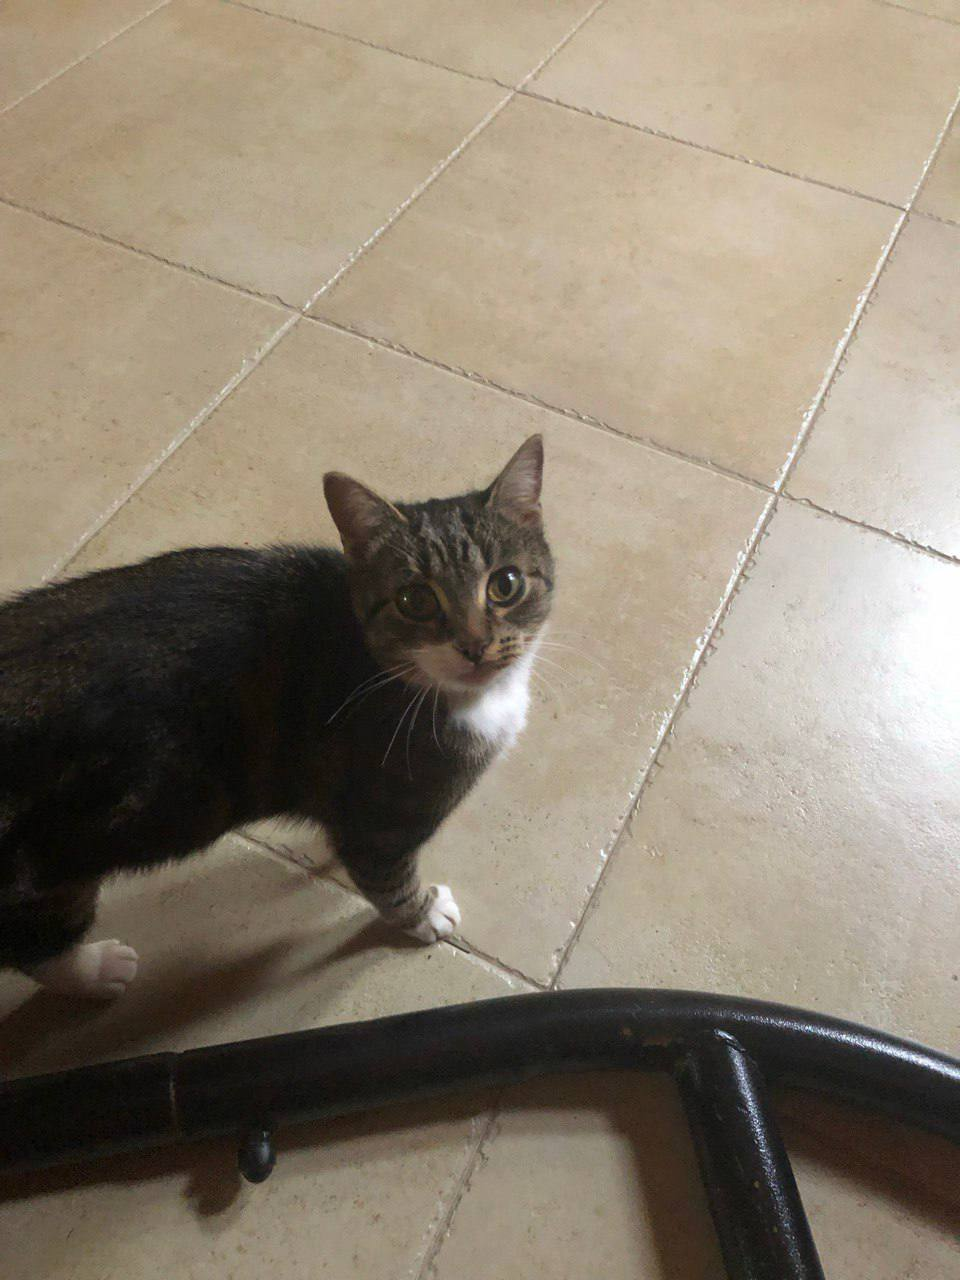

Предположу, что это кот @aketa147